In [1]:
import sys
sys.path

['d:\\Desktop\\QBM_project_repo\\quMCMC\\final_results_notebooks',
 'd:\\anaconda_neel\\python38.zip',
 'd:\\anaconda_neel\\DLLs',
 'd:\\anaconda_neel\\lib',
 'd:\\anaconda_neel',
 '',
 'd:\\anaconda_neel\\lib\\site-packages',
 'd:\\anaconda_neel\\lib\\site-packages\\locket-0.2.1-py3.8.egg',
 'd:\\anaconda_neel\\lib\\site-packages\\win32',
 'd:\\anaconda_neel\\lib\\site-packages\\win32\\lib',
 'd:\\anaconda_neel\\lib\\site-packages\\Pythonwin',
 'd:\\anaconda_neel\\lib\\site-packages\\IPython\\extensions',
 'C:\\Users\\NEELKANTH RAWAT\\.ipython']

In [2]:
sys.path.append("d:/Desktop/QBM_project_repo/quMCMC")  # Adjust the path as necessary #this is a bit strange isn't it?

In [3]:
import qumcmc

In [4]:
## import essential modules 
from qumcmc.basic_utils import *
from qumcmc.energy_models import IsingEnergyFunction, Exact_Sampling

from qumcmc.classical_mcmc_routines import classical_mcmc
from qumcmc.quantum_mcmc_routines_qulacs import quantum_enhanced_mcmc     #for Qulacs Simulator backend (** Faster )
from qumcmc.quantum_mcmc_qulacs_2 import quantum_enhanced_mcmc_2
# from qumcmc.quantum_mcmc_routines_qiskit import quantum_enhanced_mcmc   #for qiskit Aer's Simulator backend 

from qumcmc.trajectory_processing import calculate_running_js_divergence, calculate_running_kl_divergence, calculate_runnning_magnetisation, get_trajectory_statistics
from qumcmc.prob_dist import DiscreteProbabilityDistribution

### Case of BAS dataset. final plots

In [5]:
gridsize=3
bas= bas_dataset(grid_size=gridsize)
bas.dataset.sort()

     MODEL : ising model BAS 9X9 |  beta : 1.5
Num Most Probable States : 12
Entropy : 3.5849625001146053
---------------------------------------------


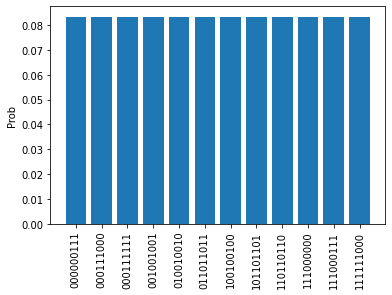

In [6]:
# consider only the bars dataset and create the weight matrix for them and create the ising model
wt = hebbing_learning(bas.bas_dict["bars"]+ bas.bas_dict["stripes"])
n_spins=gridsize*gridsize
shape_of_J=(n_spins,n_spins)
J=-1*wt
h=np.zeros(n_spins)
model=IsingEnergyFunction(J,h,name=f'ising model BAS {n_spins}X{n_spins}')

beta=1.5
## run exact sampling over all possible configurations 
exact_sampled_model = Exact_Sampling(model, beta)

## get distribution from the model
bpd= DiscreteProbabilityDistribution(exact_sampled_model.boltzmann_pd)
exact_sampled_model.sampling_summary()


In [7]:
# bas.bas_dict["stripes"]

In [8]:
from typing import Union
from qumcmc.basic_utils import plot_with_error_band

import matplotlib.colors as mcolors


def plot_proposal_and_acceptance_prob(input,list_of_list_running_kl,labels,
                                    gridsize=3,steps=50000, 
                                    std_dev_multiplicative_factor=0.5,
                                    dist: Union[str, list]=0):
    fig, axes = plt.subplots(1, 3, figsize=(15,4))
    (ax1, ax2, ax3) = axes

    num_plots=len(input)
    ### hamming plot
    for i in range(0,num_plots):
        ax1.plot(np.arange(gridsize**2+1), [r["total"]/steps for r in input[i]["hamming"].values()],
                                                    marker="o", label=labels[i])
        #ax1.set_yscale("log")
        ax1.set_ylabel("Proposal Probability")
        ax1.set_xlabel("Hamming Distance")
    ax1.legend(fontsize=8)

    ### acceptance probability
    marker_formats = ['o', 's', '^', 'D', 'v']
    # list of colors
    colors = list(mcolors.TABLEAU_COLORS.keys())[:num_plots]
    for i in range(0, num_plots):
        ax2.stem(np.arange(gridsize**2+1)+dist[i], [r["accepted"]/r["total"] if r["total"] >0 
                                            else 0 for r in input[i]["hamming"].values() ], 
                                            label=labels[i],markerfmt=marker_formats[i],
                                            linefmt=f'C{i}-') ### remove.bar
        
        # ax2.bar(np.arange(gridsize**2+1)+dist[i], [r["accepted"]/r["total"] if r["total"] >0 
        #                                     else 0 for r in input[i]["hamming"].values() ], 
        #                                     label=labels[i]) ### remove.bar
    # plt.yscale("log")
    ax2.set_ylabel("Aceptance Probability")
    ax2.set_xlabel("Hamming Distance")
    ax2.set_xticks([0,1,2,3,4,5,6,7,8,9])
    ax2.legend(fontsize=7.5)

    ### KL plot
    #xval=np.arange(0,len(list_of_list_running_kl[0][0]))
    #print("len xval is:",len(xval))
    for i in range(0,num_plots):
        xval=np.arange(0,len(list_of_list_running_kl[i][0]))
        curve_mean_value= np.mean(list_of_list_running_kl[i],axis=0)
        standard_dev_band=np.std(list_of_list_running_kl[i],axis=0)
        ax3.plot(xval, curve_mean_value, "-", label=labels[i])
        ax3.fill_between(xval, 
                            curve_mean_value-standard_dev_band*std_dev_multiplicative_factor,
                            curve_mean_value+standard_dev_band*std_dev_multiplicative_factor,
                            alpha=0.5)
    ax3.set_yscale("log")
    ax3.set_ylabel("KL Divergence")
    ax3.set_xlabel("MCMC Iteration")
    ax3.legend(loc="upper right",fontsize=7.5)


In [9]:
import pickle

In [67]:
# Load data from mcmc_wt1_bars_only.pkl
f = "BAS_final_plots_Wt1_gamma_(0.4,0.6).pkl "
with open(f, "rb") as file:
    mcmc_BAS_10_wt1 = pickle.load(file)

f = "BAS_final_plots_wt1_75_symmetric_25_gamma_(0.9,0.95).pkl "
with open(f, "rb") as file:
    mcmc_BAS_10_custom1 = pickle.load(file)

f = "BAS_final_plots_wt1_50_bars_and_stripes_symm_50_gamma_(0.9,0.95).pkl "
with open(f, "rb") as file:
    mcmc_BAS_10_custom2 = pickle.load(file)

f = "BAS_final_plots_wt1_50_bars_and_stripes_symm_50_gamma_std.pkl"
with open(f, "rb") as file:
    mcmc_BAS_std = pickle.load(file)

f = "BAS_final_plots_wt1_75_bars_symm_25_gamma_std.pkl" #"BAS_final_plots_wt1_70_bars_symm_30_gamma_std.pkl" #"BAS_final_plots_wt1_75_bars_symm_25_gamma_std.pkl"
with open(f,"rb") as file:
    mcmc_BAS_std2 = pickle.load(file)

In [68]:
mcmc_1=mcmc_BAS_10_wt1[2]
wt_1_bas_processing=get_trajectory_statistics(mcmc_chain=mcmc_1,
                                            model=exact_sampled_model
                                            )

mcmc_2=mcmc_BAS_10_custom1[3]
custom_mixers_bas_processing = get_trajectory_statistics(mcmc_chain=mcmc_2,
                                            model=exact_sampled_model)

mcmc_3=mcmc_BAS_10_custom2[4]
custom_mixers_bas_processing2 = get_trajectory_statistics(mcmc_chain=mcmc_3,
                                            model=exact_sampled_model)

mcmc_std = mcmc_BAS_std[0]
custom_mixers_std_processing = get_trajectory_statistics(mcmc_chain=mcmc_std,
                                            model=exact_sampled_model)

mcmc_std_just_bars = mcmc_BAS_std2[0]
custom_mixers_std_2_processing = get_trajectory_statistics(mcmc_chain=mcmc_std_just_bars,
                                            model=exact_sampled_model)

In [65]:
### code to get list of running kl divergences
def list_of_running_kl(list_of_mcmc_chains, bpd):
    list_kl=[]
    for i in tqdm(range(0,len(list_of_mcmc_chains))):
        kl=calculate_running_kl_divergence(bpd,
                                            mcmc_chain=list_of_mcmc_chains[i],
                                            skip_steps=1)
        list_kl.append(kl)
    
    return list_kl

list_kl_wt1=list_of_running_kl(mcmc_BAS_10_wt1, bpd=bpd)### these themselves are list of lists
list_kl_custom1=list_of_running_kl(mcmc_BAS_10_custom1, bpd=bpd)
list_kl_custom2=list_of_running_kl(mcmc_BAS_10_custom2, bpd=bpd)
list_kl_custom_std = list_of_running_kl(mcmc_BAS_std, bpd=bpd)

100%|██████████| 10/10 [00:04<00:00,  2.15it/s]


In [69]:
list_kl_custom_std2 = list_of_running_kl(mcmc_BAS_std2, bpd=bpd)

list_of_list_kl=[list_kl_wt1, list_kl_custom1,list_kl_custom2, 
                    list_kl_custom_std, list_kl_custom_std2]

100%|██████████| 10/10 [00:05<00:00,  1.86it/s]


In [71]:
mcmc_BAS_std2

[MCMCChain(),
 MCMCChain(),
 MCMCChain(),
 MCMCChain(),
 MCMCChain(),
 MCMCChain(),
 MCMCChain(),
 MCMCChain(),
 MCMCChain(),
 MCMCChain()]

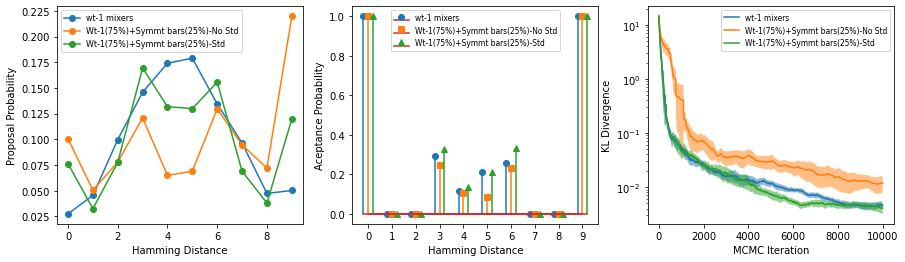

In [70]:
### generating all the plots
plot_proposal_and_acceptance_prob(input=[wt_1_bas_processing,
                                        custom_mixers_bas_processing,
                                        #custom_mixers_bas_processing2,
                                        #custom_mixers_std_processing,
                                        custom_mixers_std_2_processing],
                                        list_of_list_running_kl=[list_kl_wt1, list_kl_custom1, list_kl_custom_std2],#list_of_list_kl,
                                        steps=10000,
                                        labels=["wt-1 mixers", # 0.4,0.6: gamma range
                                                "Wt-1(75%)+Symmt bars(25%)-No Std",#0.9,0.95# gamma range
                                                #"Wt-1(50%)+Symmt bars(25%)+stripes(25%)",# 0.9,0.95 #gamma range
                                                #"Wt-1(60%)+Symmt bars(15%)+stripes(15%)-STD",
                                                "Wt-1(75%)+Symmt bars(25%)-Std"],
                                        dist=[-0.2,0,0.2])#[-0.20,-0.10,0.0,0.10,0.20]

In [17]:
### need to plot the running average

# from qumcmc.basic_utils import plot_with_error_band

# plot_with_error_band(xval=list(range(1,30000+2)),
#                         y_list_of_list=list_kl_wt1,
#                         label="Wt1-mixer")
# plt.yscale("log")

### checking the Bars dataset

     MODEL : ising model 9X9 bars only |  beta : 1.5
Num Most Probable States : 6
Entropy : 2.5849625007211547
---------------------------------------------


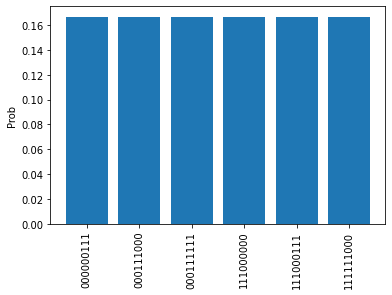

In [138]:
# consider only the bars dataset and create the weight matrix for them and create the ising model
wt = hebbing_learning(bas.bas_dict["bars"])
n_spins=gridsize*gridsize
shape_of_J=(n_spins,n_spins)
J=-1*wt
h=np.zeros(n_spins)
model=IsingEnergyFunction(J,h,name=f'ising model {n_spins}X{n_spins} bars only')

beta=1.5
## run exact sampling over all possible configurations 
exact_sampled_model = Exact_Sampling(model, beta)

## get distribution from the model
bpd= DiscreteProbabilityDistribution(exact_sampled_model.boltzmann_pd)
exact_sampled_model.sampling_summary()

In [139]:
# Load data from mcmc_wt1_bars_only.pkl
f = "Bars_final_plots_Wt1.pkl "
with open(f, "rb") as file:
    mcmc_bars_wt1= pickle.load(file)

f = "Bars_final_plots_symmetrix.pkl "
with open(f, "rb") as file:
    mcmc_bars_symmetric = pickle.load(file)

f = "Bars_final_plots_Wt3.pkl "
with open(f, "rb") as file:
    mcmc_bars_wt3 = pickle.load(file)

In [140]:
mcmc_1=mcmc_bars_wt1[2]
wt_1_bars_processing=get_trajectory_statistics(mcmc_chain=mcmc_1,
                                            model=exact_sampled_model
                                            )

mcmc_2=mcmc_bars_symmetric[2]
custom_mixers_bars_processing = get_trajectory_statistics(mcmc_chain=mcmc_2,
                                            model=exact_sampled_model)

mcmc_3=mcmc_bars_wt3[2]
custom_mixers_bars_processing2 = get_trajectory_statistics(mcmc_chain=mcmc_3,
                                            model=exact_sampled_model)

In [141]:
list_kl_wt1=list_of_running_kl(mcmc_bars_wt1, bpd=bpd)### these themselves are list of lists
list_kl_symmetric=list_of_running_kl(mcmc_bars_symmetric, bpd=bpd)
list_kl_wt3=list_of_running_kl(mcmc_bars_wt3, bpd=bpd)
list_of_list_kl=[list_kl_wt1, list_kl_symmetric, list_kl_wt3]

100%|██████████| 10/10 [00:15<00:00,  1.58s/it]


len xval is: 30001


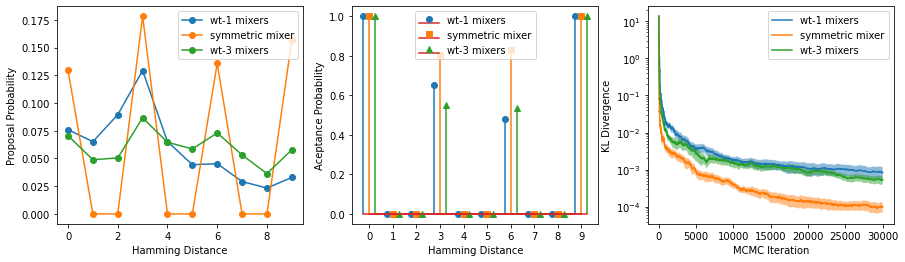

In [143]:
### generating all the plots
plot_proposal_and_acceptance_prob(input=[wt_1_bars_processing,custom_mixers_bars_processing,custom_mixers_bars_processing2],
                                    list_of_list_running_kl=list_of_list_kl,
                                    labels=["wt-1 mixers", "symmetric mixer","wt-3 mixers"],
                                    dist=[-0.25,0,0.25])

In [ ]:
### manuel bhaiya's code

# fig, axes = plt.subplots(1, 3, figsize=(15,4))
# (ax1, ax2, ax3) = axes

# ax1.plot(np.arange(gridsize**2+1), [r["total"]/steps for r in r["hamming"].values()], marker="o", label="With System H")
# ax1.plot(np.arange(gridsize**2+1), [r["total"]/steps for r in rm["hamming"].values()], marker="o", label="Mismatched H")
# ax1.plot(np.arange(gridsize**2+1), [r["total"]/steps for r in rz["hamming"].values()], marker="o", label="Without System H", color="grey")
# ax1.set_yscale("log")
# ax1.set_ylabel("Proposal Probability")
# ax1.set_xlabel("Hamming Distance")
# ax1.legend()

# ax2.bar(np.arange(gridsize**2+1)-0.8, [r["accepted"]/r["total"] if r["total"] >0 else 0 for r in hams.values() ], label="With System H")
# ax2.bar(np.arange(gridsize**2+1)-0.0, [r["accepted"]/r["total"] if r["total"] >0 else 0 for r in hams_miss.values() ], label="Mismatched H")
# ax2.bar(np.arange(gridsize**2+1)+0.8, [r["accepted"]/r["total"] if r["total"] >0 else 0 for r in hams_zero.values() ], label="Without System H", color="grey")
# # plt.yscale("log")
# ax2.set_ylabel("Aceptance Probability")
# ax2.set_xlabel("Hamming Distance")
# ax2.set_xticks([0, 3, 6, 9])
# ax2.legend()

# ax3.plot(r["kldiv"], label="With System H")
# ax3.plot(rm["kldiv"], label="Mismatched H")
# ax3.plot(rz["kldiv"], label="Without System H", color="grey")
# plt.yscale("log")
# ax3.set_ylabel("KL Divergence")
# ax3.set_xlabel("MCMC Iteration")
# ax3.legend(loc="upper right")

